# info

following [towards datascience](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501) article

Does some Bayesian inference on the "Spanish high speed rail tickets pricing" dataset that can be found [here](https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv)

## imports

In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

In [2]:
print(f"Running PyMC3 v{pm.__version__}")

Running PyMC3 v3.9.3


In [3]:
! wget "https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv"

--2020-09-24 13:06:38--  https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.60.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.60.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2647932 (2.5M) [text/plain]
Saving to: ‘renfe_small.csv.1’

renfe_small.csv.1   100%[===================>]   2.52M  10.1MB/s    in 0.2s    

2020-09-24 13:06:39 (10.1 MB/s) - ‘renfe_small.csv.1’ saved [2647932/2647932]



In [4]:
data = pd.read_csv("renfe_small.csv")

In [5]:
data

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
1,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
2,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
3,2019-04-24 06:21:57,SEVILLA,MADRID,2019-05-03 08:35:00,2019-05-03 15:26:00,LD-MD,34.35,Turista con enlace,Promo +
4,2019-04-19 21:13:55,VALENCIA,MADRID,2019-05-10 09:40:00,2019-05-10 11:20:00,AVE,45.30,Turista,Promo
...,...,...,...,...,...,...,...,...,...
25793,2019-05-01 11:45:12,PONFERRADA,MADRID,2019-05-13 02:36:00,2019-05-13 09:31:00,TRENHOTEL,45.80,Turista,Flexible
25794,2019-04-24 19:26:17,MADRID,SEVILLA,2019-05-25 08:00:00,2019-05-25 10:32:00,AVE,61.45,Preferente,Promo
25795,2019-05-06 13:04:53,MADRID,SEVILLA,2019-05-26 18:00:00,2019-05-26 20:32:00,AVE,60.30,Turista,Promo
25796,2019-05-08 15:00:51,MADRID,SEVILLA,2019-05-14 13:10:00,2019-05-14 20:51:00,MD-LD,34.35,Turista con enlace,Promo +


In [6]:
print("summary shows the fraction of cases per column that have NaNs i.e., missing data:\n")
data.isnull().sum()/len(data)

summary shows the fraction of cases per column that have NaNs i.e., missing data:



insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

In [7]:
# fill NA/NaN 'train_class' and 'fare' with mode values
most_common_train_class = data['train_class'].mode().iloc[0]
most_common_fare = data['fare'].mode().iloc[0]

data['train_class'] = data['train_class'].fillna(most_common_train_class)
data['fare'] = data['fare'].fillna(most_common_fare)

# fill NaN 'price' with mean values of 'fare' types
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

In [8]:
data.groupby('fare').sum()

,price
fare,
Adulto ida,5.475278e+04
Flexible,4.827780e+05
Individual-Flexible,4.518000e+02
Mesa,7.240000e+02
Promo,1.088194e+06
Promo +,2.691974e+04


In [9]:
data['price'].values

array([82.07718924, 21.95      , 38.55      , ..., 60.3       ,
       34.35      , 82.07718924])

Text(0.5, 0, 'price')

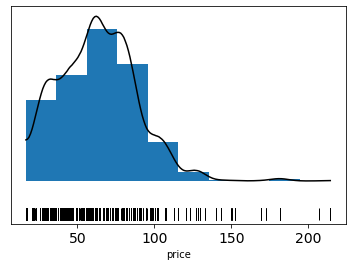

In [10]:
plt.figure()
plt.hist(data['price'].values, density=True)
az.plot_kde(data['price'].values, plot_kwargs={'c':'k'}, rug=True)
plt.yticks([]);
plt.xlabel("price")

In [11]:
# this could be a Gaussian distribution with a tail at high prices
# lets assume a Gaussian for our model of the price distribution data
# we do not know the mean or standard deviation so we must set priors for them

## model

In [12]:
# we perform inference on the ticket price data

In [13]:
with pm.Model() as model_g:
    mean = pm.Uniform('mean', lower=0, upper=300)
    std = pm.Uniform('std', lower=1e-3, upper=100)
    y = pm.Normal('y', mu=mean, sd=std, observed=data['price'].values)

In [15]:
with model_g:
    trace_g = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


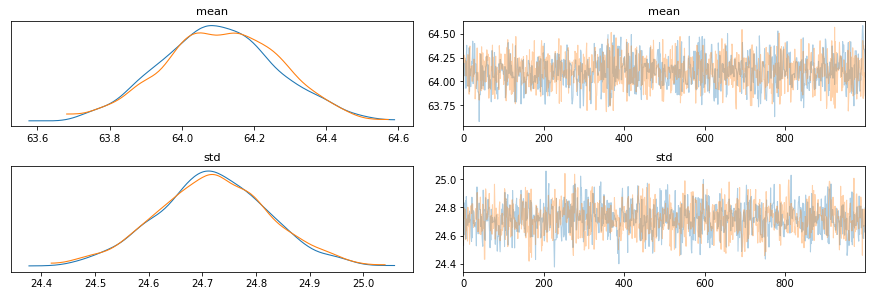

In [17]:
with model_g:
    az.plot_trace(trace_g)

In [18]:
trace_g

<MultiTrace: 2 chains, 1000 iterations, 4 variables>

In [26]:
loc=np.median(trace_g["mean"])
print(loc)

64.10356745934763


In [27]:
scale=np.median(trace_g["std"])
print(scale)

24.71893559487562


In [24]:
gauss = stats.norm

In [33]:
x = np.linspace(min(data['price'].values), max(data['price'].values), 1000)

In [34]:
yhat = gauss.pdf(x, loc=loc, scale=scale)

Text(0.5, 0, 'price')

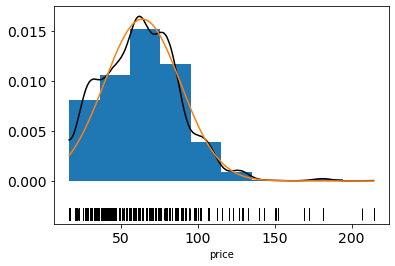

In [38]:
plt.figure()
plt.hist(data['price'].values, density=True)
az.plot_kde(data['price'].values, plot_kwargs={'c':'k'}, rug=True)
plt.plot(x, yhat)
# plt.yticks([]);
plt.xlabel("price")
# plt.yscale('log')

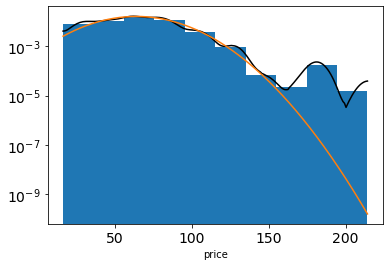

In [37]:
plt.figure()
plt.hist(data['price'].values, density=True)
az.plot_kde(data['price'].values, plot_kwargs={'c':'k'}, rug=True)
plt.plot(x, yhat)
# plt.yticks([]);
plt.xlabel("price")
plt.yscale('log')